#### Home Assigment 2, CMPE 260, Spring 2022, SJSU.

**Question 2 (15 points): MDP - model-free solution in the tabular case**. In this question you will solve MDP by **q-learnig** from samples (unknown model)

Importing the necessary libraries:

In [1]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
import numpy as np
import random
import copy
%matplotlib inline

In [2]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = 15,15 # Added For Visual Ease

Initialize the environment as per the problem statement:

In [4]:
GRID_SIZE = 15

# rewards
R_GOAL = 0
R_HIT_WALL = -5
R_STEP = -1

START = (0, 0)
GOAL = (GRID_SIZE - 1, GRID_SIZE - 1)

# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise
ALPHA = 0.01

# learning rate
lr = 0.1

A_LIST = ['up', 'down', 'left', 'right', 'stay']
EPSILON = 0.2

EPISODE_LENGTH_MAX = 500

Define the Maze. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [5]:
# State Space
S = np.zeros((GRID_SIZE, GRID_SIZE))

# horizontal walls
S[3, 0:12] = 1
S[5, 10: ] = 1
S[8, 3:12] = 1
S[11, 4: ] = 1

# vertical walls
S[8:12, 2] = 2

# goal state
S[GOAL]    = 3

Visualize the maze

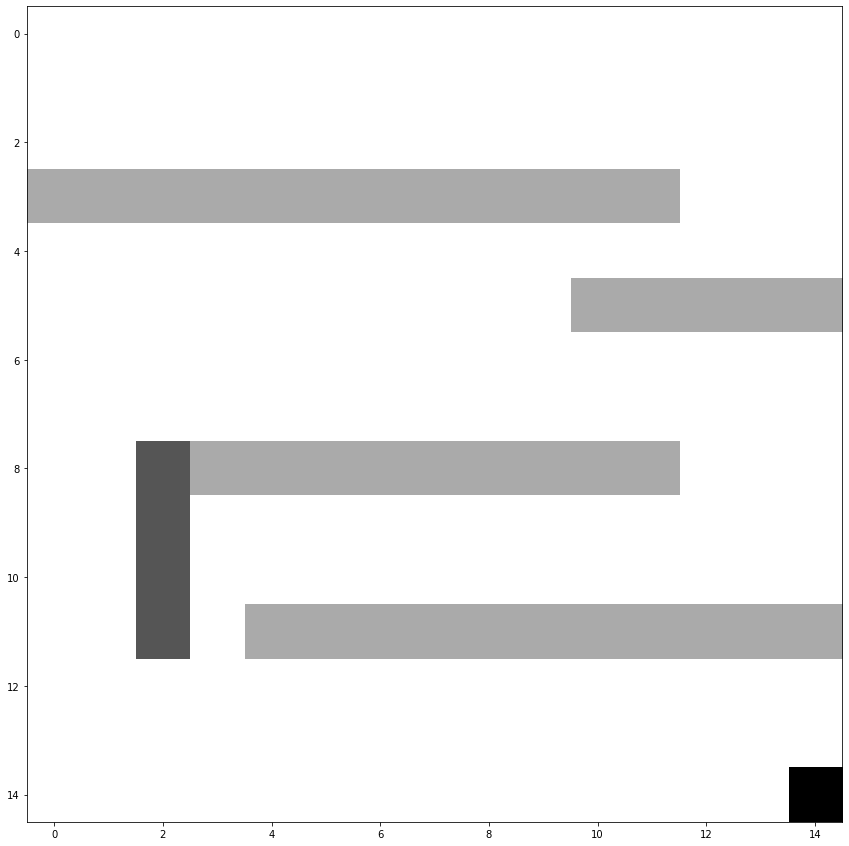

In [6]:
plt.imshow(S, cmap='binary')

In [7]:
S[12:15, 2] = 2 # Added Wall
#S[6:8, 10] = 2 # Added Wall

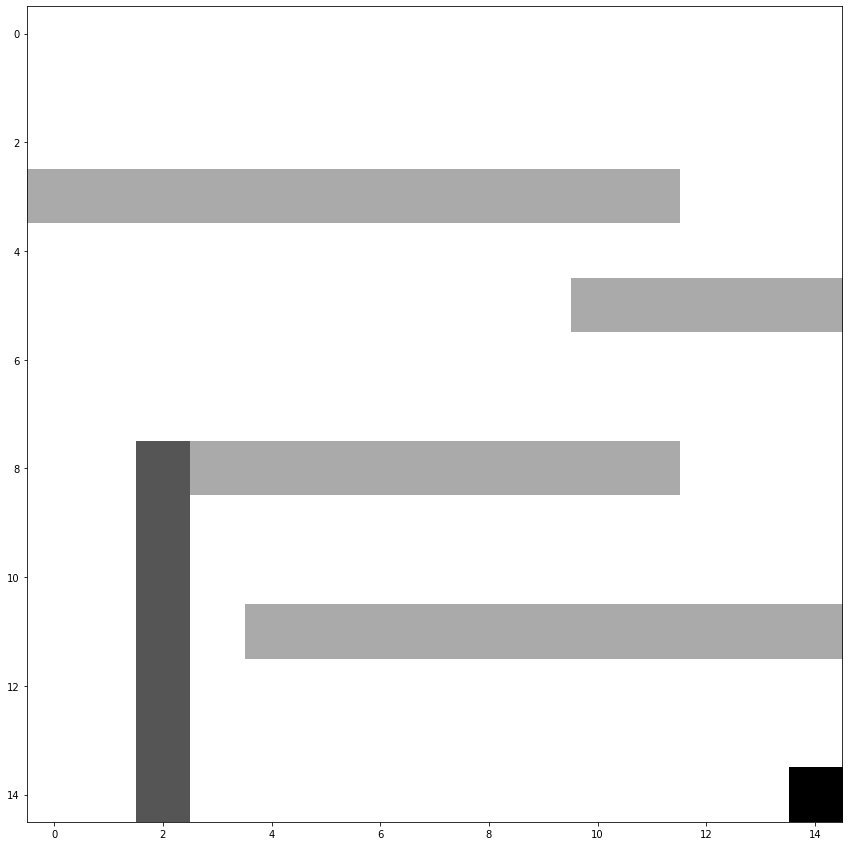

In [8]:
plt.imshow(S, cmap='binary')

State transition dynamics check

In [9]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

We assume that the environment assigns rewards using the following reward function. Note that this reward function is not visible to the agent, which can only learn from the observation samples.

In [10]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return R_GOAL
    elif hit_wall(s, a):
        return R_HIT_WALL
    else:
        return R_STEP

We define a utility function s_next_calc, which calculates the next state given current state and action:

In [11]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

The agent will use the following function to stochastically perform an action and obtains the next state and the associated reward.

In [12]:
def step(s, a):
    '''This function stochastically performs the action 'a' on the given
    state s.
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid and the reward
    '''
    action_list = [a]
    cum_prob_list = [1 - ALPHA]
    for action in range(len(A)):
        if action != a:
            action_list.append(a)
            cum_prob_list.append(action)

    action_taken = random.choices(action_list, cum_weights=cum_prob_list)[0]
    r = R(s, action_taken)
    if r == R_HIT_WALL or R_GOAL: # can't move
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r
    

We will use the following function to choose an action for the state from Q using a basic epsilon-greedy implementation:

In [13]:
def choose_action_epsilon(Q, s, episode):
    """return a string action"""
    if random.uniform(0, 1) < EPSILON: # Added Epsilon
        return random.randint(0, len(A)-1)
    return np.argmax(Q[s[0], s[1], :])

The agent uses the following function for Q-Learning:

In [14]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1], k[0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

In [15]:
def q_learning(gamma, episodes, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param episodes: Number of episodes to be run
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        s = START
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Pick the best known or random action
            a = choose_action_epsilon(Q, s, episode)

            # Take a random action with a transition probability ALPHA
            s_next, r = step(s, a)

            # Update Q table
            max_q_next = np.max(Q[s_next[0]][s_next[1]])
            Q[s[0]][s[1]][a] += (r + (gamma * np.max(max_q_next - Q[s[0]][s[1]][a])))
            
            # I found that not adding the learning rate at "...+= lr * (r +...)"
            # gave convergence and did so quickly.
            
            s = s_next
            r_sum += r
            i += 1

        sum_steps += i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return r_list

Run the Q-learning algorithm:

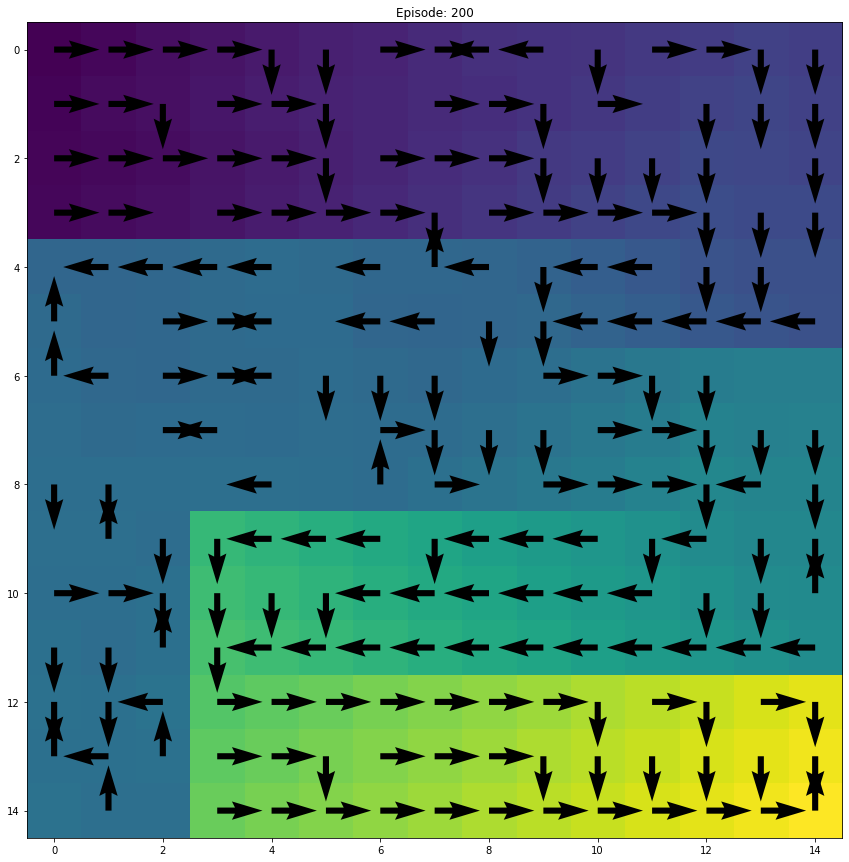

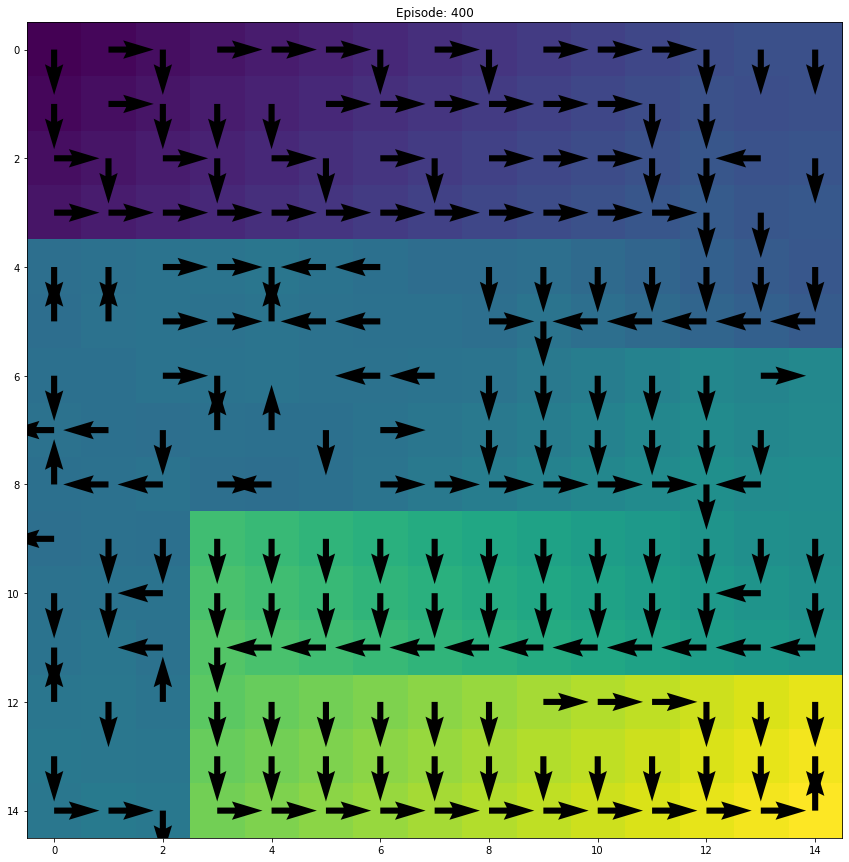

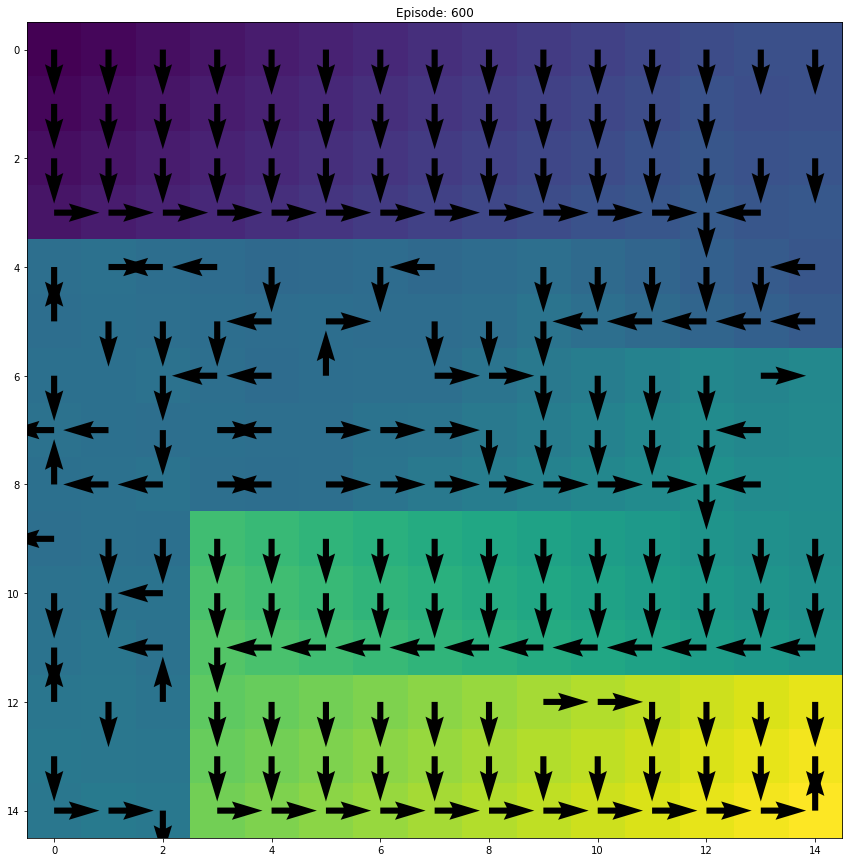

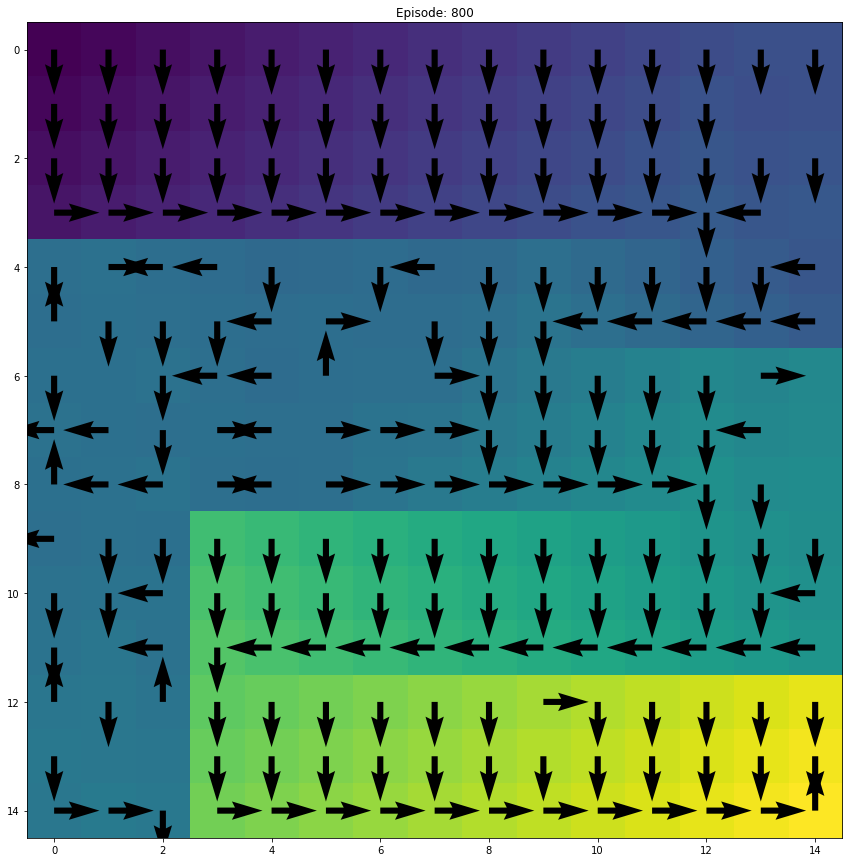

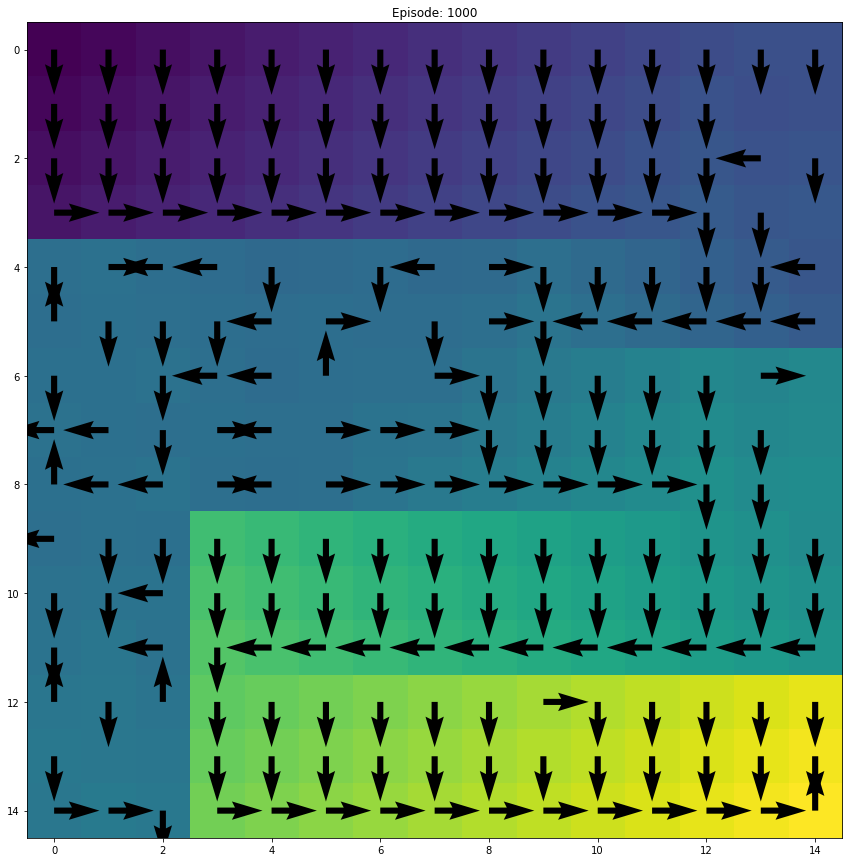

In [16]:
eps = 1000
r_list = q_learning(0.9, eps)

Plot the rewards obtained in each episode

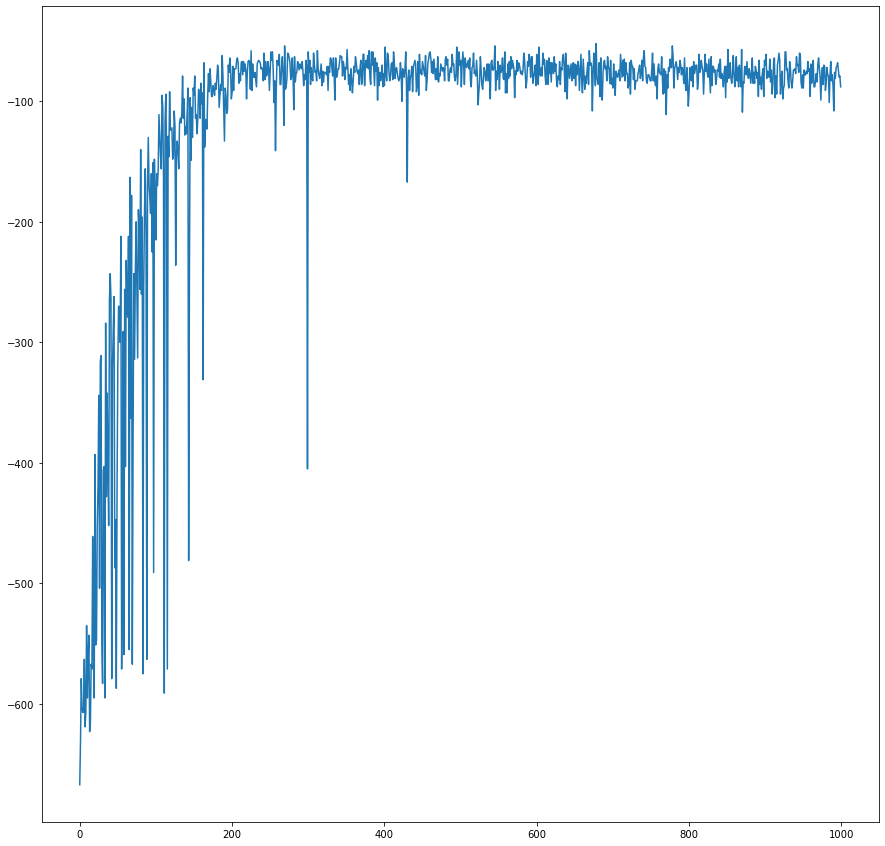

In [17]:
plt.plot(range(eps), r_list)

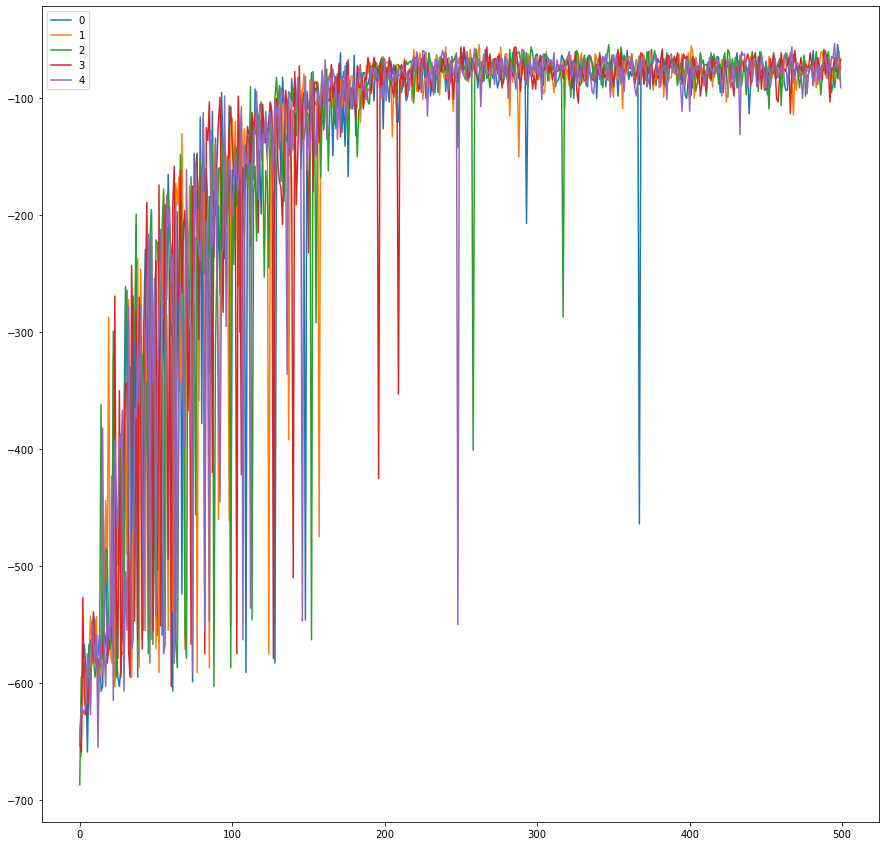

In [18]:
# Q - Table
for i in range(5):
    plt.plot(range(500), q_learning(0.9, 500, show=False), label=i)
plt.legend()
plt.show()

**Summarize briefly insights and your observations in Question 2.** 